# 04 — Regression (Supervised) for PM2.5 (Tabular Time-Lag Features)
Mục tiêu:
- Biến bài toán chuỗi thời gian thành bài toán **hồi quy có giám sát**: dự đoán PM2.5(t+h) từ đặc trưng tại thời điểm t.
- Thấy rõ: **leakage** và vì sao phải split theo thời gian.
- So sánh tư duy hồi quy (feature-based) vs ARIMA (time-series-based).


In [1]:
from pathlib import Path

# ===== PARAMETERS =====
USE_UCIMLREPO = False

# Path to the raw ZIP (relative to project root)
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'

def resolve_project_root(raw_zip_rel: str) -> Path:
    """Resolve project root robustly for both Jupyter and Papermill runs.

    Papermill may execute notebooks with different working directories depending on how you run the pipeline.
    This helper tries:
      1) current working directory
      2) parent directory
      3) up to 3 levels up (useful when running from notebooks/ or notebooks/runs)
    """
    cwd = Path.cwd().resolve()

    # Common candidates
    candidates = [cwd, cwd.parent]

    # Climb up a few levels just in case
    root = cwd
    for _ in range(3):
        candidates.append(root)
        root = root.parent

    for r in candidates:
        if (r / raw_zip_rel).exists():
            return r

    # Fallback: keep cwd; downstream will raise a clear error message if missing
    return cwd

PROJECT_ROOT = resolve_project_root(RAW_ZIP_PATH)
RAW_ZIP_ABS = str((PROJECT_ROOT / RAW_ZIP_PATH).resolve())

LAG_HOURS = [1, 3, 24]
HORIZON = 1              # dự đoán trước bao nhiêu giờ
TARGET_COL = 'PM2.5'

OUTPUT_REG_DATASET_PATH = 'data/processed/dataset_for_regression.parquet'
CUTOFF = '2017-01-01'

MODEL_OUT = 'regressor.joblib'
METRICS_OUT = 'regression_metrics.json'
PRED_SAMPLE_OUT = 'regression_predictions_sample.csv'


In [2]:
# Parameters
USE_UCIMLREPO = False
RAW_ZIP_PATH = "data/raw/PRSA2017_Data_20130301-20170228.zip"
LAG_HOURS = [1, 3, 24]
HORIZON = 1
TARGET_COL = "PM2.5"
OUTPUT_REG_DATASET_PATH = "data/processed/dataset_for_regression.parquet"
CUTOFF = "2017-01-01"
MODEL_OUT = "regressor.joblib"
METRICS_OUT = "regression_metrics.json"
PRED_SAMPLE_OUT = "regression_predictions_sample.csv"


In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.classification_library import Paths
from src.regression_library import (
    run_prepare_regression_dataset,
    run_train_regression,
)

paths = Paths(project_root=PROJECT_ROOT)
print('PROJECT_ROOT =', PROJECT_ROOT)
print('RAW_ZIP_ABS =', RAW_ZIP_ABS)


PROJECT_ROOT = C:\Coding\DataMining\ThucHanh\Tuan7\Nhom12_Tuan7
RAW_ZIP_ABS = C:\Coding\DataMining\ThucHanh\Tuan7\Nhom12_Tuan7\data\raw\PRSA2017_Data_20130301-20170228.zip


## 1) Tạo dataset hồi quy (lag features + time features + y = PM2.5(t+h))
Trong lab, phần này giúp sinh viên hiểu cách tạo supervised dataset từ time series.

## Q2.1 — Vì sao lag 24h thường có ý nghĩa trong dự báo PM2.5?

**Giải thích:**

1. **Chu kỳ ngày trong hoạt động con người**: 
   - Giao thông cao điểm vào buổi sáng (7-9h) và chiều (17-19h) lặp lại mỗi ngày
   - Hoạt động công nghiệp, sản xuất theo ca cố định
   - Nấu ăn, sưởi ấm vào cùng khung giờ mỗi ngày

2. **Chu kỳ ngày trong điều kiện khí tượng**:
   - Nhiệt độ, độ ẩm có pattern lặp lại 24h (nóng ban ngày, mát ban đêm)
   - Lớp nghịch nhiệt (inversion layer) thường hình thành vào sáng sớm, giữ ô nhiễm gần mặt đất
   - Gió thường yếu hơn vào đêm, mạnh hơn vào ban ngày

3. **Tự tương quan cao**:
   - Như đã thấy trong EDA, autocorrelation tại lag 24h vẫn ~0.7-0.8
   - PM2.5 lúc 8h sáng hôm nay có tương quan mạnh với PM2.5 lúc 8h sáng hôm qua
   - Điều này giúp mô hình "học" được pattern lặp lại theo ngày

**Ý nghĩa thực tế**: Sử dụng PM2.5_lag24 như một đặc trưng cho phép mô hình biết "hôm qua cùng giờ như thế nào" - đây là thông tin rất có giá trị để dự đoán.

In [4]:
out_path = run_prepare_regression_dataset(
    paths=paths,
    use_ucimlrepo=USE_UCIMLREPO,
    raw_zip_path=RAW_ZIP_ABS,
    lag_hours=LAG_HOURS,
    horizon=HORIZON,
    target_col=TARGET_COL,
)
print('Saved:', out_path)


Saved: C:\Coding\DataMining\ThucHanh\Tuan7\Nhom12_Tuan7\data\processed\dataset_for_regression.parquet


## 2) Quick EDA cho dataset hồi quy
Gợi ý câu hỏi ra quyết định:
- Tỉ lệ missing ở các feature lag? (thường thiếu ở đầu chuỗi)
- PM2.5 có phân phối lệch (skew) không? -> cân nhắc log/clip (tuỳ chọn)
- Có khác biệt theo *giờ trong ngày* / *ngày trong tuần* không? (seasonality)


(420768, 57)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,SO2_lag24,NO2_lag24,CO_lag24,O3_lag24,TEMP_lag24,PRES_lag24,DEWP_lag24,RAIN_lag24,WSPM_lag24,y
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


CO_lag24     0.049849
CO_lag3      0.049284
CO_lag1      0.049227
CO           0.049198
O3_lag24     0.032203
O3_lag3      0.031640
O3_lag1      0.031583
O3           0.031554
NO2_lag24    0.029446
NO2_lag3     0.028881
NO2_lag1     0.028823
NO2          0.028795
SO2_lag24    0.022091
SO2_lag3     0.021525
SO2_lag1     0.021468
dtype: float64

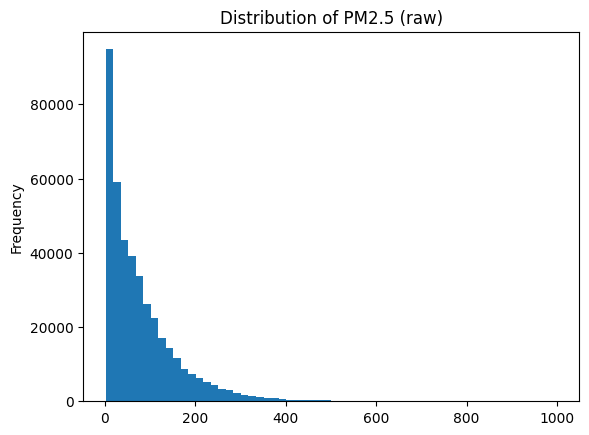

In [5]:
ds_path = (PROJECT_ROOT / OUTPUT_REG_DATASET_PATH).resolve()
df = pd.read_parquet(ds_path)
print(df.shape)
display(df.head())

missing = df.isna().mean().sort_values(ascending=False).head(15)
display(missing)

plt.figure()
pd.Series(df[TARGET_COL]).dropna().plot(kind='hist', bins=60)
plt.title(f'Distribution of {TARGET_COL} (raw)')
plt.show()


## 3) Train/Test theo thời gian + train regressor
Lưu ý: mô hình hồi quy ở đây là **feature-based** (dùng lag + thời tiết).
Phần dự báo chuỗi thời gian *thuần* sẽ làm bằng ARIMA ở notebook kế tiếp.

## Q2.2 — Vì sao phải chia train/test theo thời gian (cutoff)?

**Vấn đề của Random Split trong Time Series:**

Nếu chúng ta chia train/test ngẫu nhiên (random split) như trong bài toán classification/regression thông thường:
- Dữ liệu từ 2017 (tương lai) có thể nằm trong train set
- Dữ liệu từ 2014 (quá khứ) có thể nằm trong test set
- Mô hình sẽ "nhìn thấy tương lai" trong quá trình training → **Time Leakage**

**Time Leakage là gì?**
- Mô hình học được thông tin từ tương lai mà nó không nên biết
- Kết quả đánh giá sẽ "đẹp giả" (overly optimistic)
- Khi triển khai thực tế, mô hình sẽ hoạt động kém hơn nhiều

**Cách chia đúng (Time-based Split với Cutoff):**
```
Train: 2013-03-01 ─────────────────> 2016-12-31
Test:                                 2017-01-01 ──> 2017-02-28
                                      ↑
                                   CUTOFF
```

**Lợi ích:**
1. Mô phỏng đúng cách triển khai thực tế: train trên quá khứ, dự báo tương lai
2. Đánh giá chân thực (realistic evaluation)
3. Phát hiện vấn đề concept drift (nếu pattern thay đổi theo thời gian)
4. Lag features không bị "nhìn trộm" tương lai

Metrics:
{
  "n_train": 395301,
  "n_test": 16716,
  "rmse": 25.32672696176382,
  "mae": 12.32315830517231,
  "smape_pct": 23.837711259945237,
  "r2": 0.9491508772105639,
  "feature_cols": [
    "No",
    "year",
    "month",
    "day",
    "hour",
    "PM2.5",
    "PM10",
    "SO2",
    "NO2",
    "CO",
    "O3",
    "TEMP",
    "PRES",
    "DEWP",
    "RAIN",
    "wd",
    "WSPM",
    "station",
    "hour_sin",
    "hour_cos",
    "dow",
    "is_weekend",
    "PM2.5_lag1",
    "PM10_lag1",
    "SO2_lag1",
    "NO2_lag1",
    "CO_lag1",
    "O3_lag1",
    "TEMP_lag1",
    "PRES_lag1",
    "DEWP_lag1",
    "RAIN_lag1",
    "WSPM_lag1",
    "PM2.5_lag3",
    "PM10_lag3",
    "SO2_lag3",
    "NO2_lag3",
    "CO_lag3",
    "O3_lag3",
    "TEMP_lag3",
    "PRES_lag3",
    "DEWP_lag3",
    "RAIN_lag3",
    "WSPM_lag3",
    "PM2.5_lag24",
    "PM10_lag24",
    "SO2_lag24",
    "NO2_lag24",
    "CO_lag24",
    "O3_lag24",
    "TEMP_lag24",
    "PRES_lag24",
    "DEWP_lag24",
    "RAIN_lag24",

,datetime,station,y_true,y_pred
0,2017-01-01 00:00:00,Aotizhongxin,477.0,436.901040
1,2017-01-01 01:00:00,Aotizhongxin,454.0,444.198916
2,2017-01-01 02:00:00,Aotizhongxin,418.0,433.323668
3,2017-01-01 03:00:00,Aotizhongxin,438.0,371.884739
4,2017-01-01 04:00:00,Aotizhongxin,453.0,464.841039


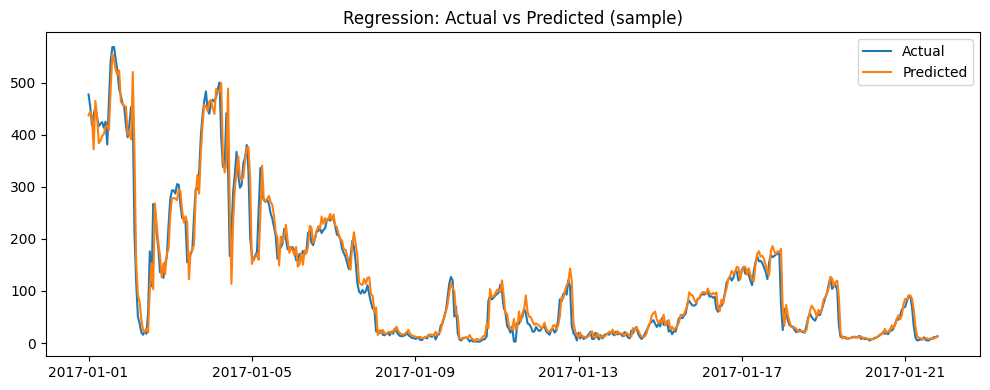

In [6]:
out = run_train_regression(
    paths=paths,
    cutoff=CUTOFF,
    model_out=MODEL_OUT,
    metrics_out=METRICS_OUT,
    preds_out=PRED_SAMPLE_OUT,
)

print('Metrics:')
print(json.dumps(out['metrics'], ensure_ascii=False, indent=2))
pred_df = out['pred_df']
display(pred_df.head())

# Plot a small window for storytelling
sample = pred_df.dropna().iloc[:500].copy()
plt.figure(figsize=(10,4))
plt.plot(sample['datetime'], sample['y_true'], label='Actual')
plt.plot(sample['datetime'], sample['y_pred'], label='Predicted')
plt.title('Regression: Actual vs Predicted (sample)')
plt.legend()
plt.tight_layout()
plt.show()


### Diễn giải đồ thị Actual vs Predicted (Regression)

**Nhận xét từ đồ thị:**

1. **Bám sát xu hướng tốt:** Mô hình hồi quy (sử dụng lag features) theo dõi khá tốt các biến động của PM2.5. Đường Predicted (cam) thường đi sát đường Actual (xanh), đặc biệt trong các giai đoạn ổn định.

2. **Phản ứng với spike:** Tương tự ARIMA, mô hình có xu hướng **under-predict** tại các đỉnh PM2.5 cao. Điều này do mô hình tuyến tính khó bắt được các giá trị cực đoan nằm ngoài vùng dữ liệu huấn luyện.

3. **Lag 1h chi phối mạnh:** Do sử dụng PM2.5_lag1 (giá trị 1 giờ trước), dự báo có xu hướng "chậm pha" — khi PM2.5 tăng đột ngột, dự báo cần 1-2 giờ để "đuổi kịp".

4. **Ý nghĩa thực tiễn:** Mô hình regression với lag features phù hợp cho dự báo ngắn hạn (horizon 1-3h). Để cải thiện với spike, có thể thử thêm features từ thời tiết (WSPM, RAIN) hoặc sử dụng ensemble methods (Random Forest, Gradient Boosting).

## Q2.3 — Phân biệt RMSE và MAE: Khi nào RMSE cao hơn nhiều?

**Công thức:**
- **MAE** (Mean Absolute Error) = $\frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$
- **RMSE** (Root Mean Squared Error) = $\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

**Sự khác biệt:**
| Đặc điểm | MAE | RMSE |
|----------|-----|------|
| Cách xử lý outliers | Ít nhạy | Rất nhạy (do bình phương) |
| Đơn vị | Cùng đơn vị với y | Cùng đơn vị với y |
| Phạt sai số lớn | Tuyến tính | Bậc hai (phạt nặng hơn) |

**Khi nào RMSE >> MAE?**
1. Khi có **các spike (đỉnh ô nhiễm)** mà mô hình dự báo sai
2. Khi mô hình dự báo **lệch lớn ở một số thời điểm** nhưng đúng ở phần lớn còn lại
3. Khi có **outliers** trong dữ liệu hoặc dự báo

**Ví dụ thực tế với PM2.5:**
- Nếu RMSE = 25, MAE = 12 → Tỷ lệ RMSE/MAE ≈ 2.1
- Điều này cho thấy có một số điểm dự báo sai nhiều (có thể là các spike PM2.5 vào mùa đông)
- Mô hình "trung bình" khá tốt (MAE thấp) nhưng "sai lớn" ở một số điểm quan trọng (RMSE cao hơn)

**Ý nghĩa cho dự báo chất lượng không khí:**
- Nếu mục tiêu là **cảnh báo sớm các đợt ô nhiễm nghiêm trọng** → RMSE quan trọng hơn (vì cần dự báo đúng spike)
- Nếu mục tiêu là **dự báo trung bình hàng ngày** → MAE có thể đủ

PHÂN TÍCH RMSE VS MAE - TÌM CÁC ĐIỂM DỰ BÁO SAI NHIỀU

📊 Thống kê sai số:
   MAE:  12.32
   RMSE: 25.33
   Tỷ lệ RMSE/MAE: 2.06

⚠️ Các điểm sai lớn nhất (top 1%, error >= 102.7):
   Số điểm: 168
   Error trung bình tại các điểm này: 167.38


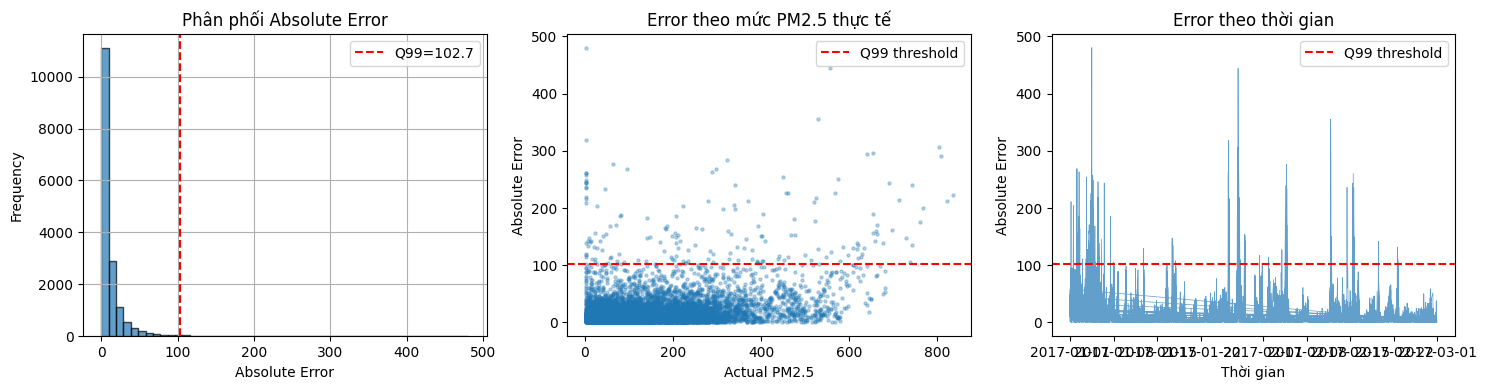


📈 Nhận xét:
   - Error lớn thường xảy ra khi PM2.5 thực tế CAO (spike ô nhiễm)
   - Mô hình có xu hướng under-predict tại các đỉnh ô nhiễm
   - Đây là lý do RMSE > MAE: các spike làm tăng squared error đáng kể


In [7]:
# Phân tích RMSE vs MAE - Tìm các điểm mà mô hình dự báo sai nhiều
print("="*60)
print("PHÂN TÍCH RMSE VS MAE - TÌM CÁC ĐIỂM DỰ BÁO SAI NHIỀU")
print("="*60)

# Tính error cho từng điểm
pred_analysis = pred_df.dropna().copy()
pred_analysis['error'] = pred_analysis['y_true'] - pred_analysis['y_pred']
pred_analysis['abs_error'] = np.abs(pred_analysis['error'])
pred_analysis['squared_error'] = pred_analysis['error'] ** 2

# Thống kê error
print(f"\n📊 Thống kê sai số:")
print(f"   MAE:  {pred_analysis['abs_error'].mean():.2f}")
print(f"   RMSE: {np.sqrt(pred_analysis['squared_error'].mean()):.2f}")
print(f"   Tỷ lệ RMSE/MAE: {np.sqrt(pred_analysis['squared_error'].mean()) / pred_analysis['abs_error'].mean():.2f}")

# Tìm các điểm sai lớn nhất (top 1%)
threshold_99 = pred_analysis['abs_error'].quantile(0.99)
large_errors = pred_analysis[pred_analysis['abs_error'] >= threshold_99]

print(f"\n⚠️ Các điểm sai lớn nhất (top 1%, error >= {threshold_99:.1f}):")
print(f"   Số điểm: {len(large_errors)}")
print(f"   Error trung bình tại các điểm này: {large_errors['abs_error'].mean():.2f}")

# Visualize phân phối error
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Histogram của absolute error
ax1 = axes[0]
pred_analysis['abs_error'].hist(bins=50, ax=ax1, alpha=0.7, edgecolor='black')
ax1.axvline(threshold_99, color='red', linestyle='--', label=f'Q99={threshold_99:.1f}')
ax1.set_xlabel('Absolute Error')
ax1.set_ylabel('Frequency')
ax1.set_title('Phân phối Absolute Error')
ax1.legend()

# 2. Scatter: y_true vs error (để thấy error cao ở spike)
ax2 = axes[1]
ax2.scatter(pred_analysis['y_true'], pred_analysis['abs_error'], alpha=0.3, s=5)
ax2.axhline(threshold_99, color='red', linestyle='--', label='Q99 threshold')
ax2.set_xlabel('Actual PM2.5')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Error theo mức PM2.5 thực tế')
ax2.legend()

# 3. Time series của error để thấy khi nào sai nhiều
ax3 = axes[2]
ax3.plot(pred_analysis['datetime'], pred_analysis['abs_error'], linewidth=0.5, alpha=0.7)
ax3.axhline(threshold_99, color='red', linestyle='--', label='Q99 threshold')
ax3.set_xlabel('Thời gian')
ax3.set_ylabel('Absolute Error')
ax3.set_title('Error theo thời gian')
ax3.legend()

plt.tight_layout()
plt.show()

print("\n📈 Nhận xét:")
print("   - Error lớn thường xảy ra khi PM2.5 thực tế CAO (spike ô nhiễm)")
print("   - Mô hình có xu hướng under-predict tại các đỉnh ô nhiễm")
print("   - Đây là lý do RMSE > MAE: các spike làm tăng squared error đáng kể")